In [2]:
import numpy as np
from numpy import save
from numpy import load
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import lava.lib.dl.slayer as slayer
from tqdm import tqdm
import os
from loss import DECOLLELoss
from assistant_fixed import HybridAssistant
from torch.nn.functional import one_hot

## Dataset creation
### This makes and SAVES the dataset, we want to keep the SAME one across all our training

In [3]:
# Creating the dataset
np.random.seed(0)

n_train = 5000 # 1,000,000 in the original paper
n_val = 1000 # 8192 in the original paper
n_prot = 20 # 200 prototypes in the original paper
n_class = 10 # 100 classes in the original paper

layer_sizes = [50, 500, 50, 2500] # These are same as the original

n_ors = layer_sizes[0] # 50 olfactory receptors
n_timepoints = 150 # Number of timepoints per sample in the dataset
batch_size = 256

# The "prototype smells" for each class; the prototype closest to the
# smell in euclidean space determines the smell's class (BUT NOT DIRECTLY)
prototypes = np.random.uniform(0,1, (n_prot, n_ors)).astype(np.float32)

train_x = np.random.uniform(0,1, (n_train, n_ors)).astype(np.float32)
val_x = np.random.uniform(0,1, (n_val, n_ors)).astype(np.float32)

def get_labels(prototypes, odors):
    ''' The prototype with the shortest Euclidean distance to each smell
        becomes the smell's label'''
    # Calculating euclidean distances for each odor, across all prototypes
    dist = euclidean_distances(prototypes, odors)
    # Finding the prototype with the minimum distance to each smell, and partitioning
    # into the ACTUAL CLASS (just assume they're put next to each other)
    return np.argmin(dist, axis=0)//2

train_y = get_labels(prototypes, train_x).astype(np.int32)
val_y = get_labels(prototypes, val_x).astype(np.int32)

# Stacking the input to 300 timepoints
train_x = train_x.transpose()
val_x = val_x.transpose()
train_x = np.repeat(train_x[:, np.newaxis, :], n_timepoints, axis=1)
val_x = np.repeat(val_x[:, np.newaxis, :], n_timepoints, axis=1)
train_x = torch.tensor(train_x)
val_x = torch.tensor(val_x)

class ORDataset(Dataset):
    """Dataset operating on olfactory receptors"""

    def __init__(self, input, labels):
        """
        Arguments:
            dataset (np.ndarray): the olfactory receptor dataset, in the shape
                of (n_ors, n_timepoints, n_samples)
        """
        self.input = input
        self.labels = labels

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.input[:,:,idx], self.labels[idx])

# # Saving datasets
# data_folder = os.path.join(os.getcwd(),'Data')
# os.makedirs(data_folder, exist_ok=True)

# save(os.path.join(data_folder, 'train_x'), train_x)
# save(os.path.join(data_folder, 'train_y'), train_y)
# save(os.path.join(data_folder, 'val_x'), val_x)
# save(os.path.join(data_folder, 'val_y'), val_y)

## Loading pre-saved dataset and putting into dataloader

In [4]:
data_folder = 'Data'
train_x = load(os.path.join(data_folder, 'train_x.npy'))
train_y = load(os.path.join(data_folder, 'train_y.npy'))
val_x = load(os.path.join(data_folder, 'val_x.npy'))
val_y = load(os.path.join(data_folder, 'val_y.npy'))

train_dataset = ORDataset(train_x, train_y)
test_dataset = ORDataset(val_x, val_y)

training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Network definition + initialization

In [8]:
class HybridNetwork(torch.nn.Module):
    def __init__(self, layer_sizes,
                 n_class, stdp_learning_rate,
                 stdp_tau_combined, train_hybrid, burn_in=0):

        super(HybridNetwork, self).__init__()

        self.burn_in = burn_in
        self.stdp_learning_rate = stdp_learning_rate
        self.stdp_tau_combined = stdp_tau_combined
        self.layer_sizes = layer_sizes
        self.train_hybrid = train_hybrid

        # Input neuron parameters, threshold set to 1 as per course guidelines
        input_neuron_parameters = {
            'threshold': 1.,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }
        # Default values in SLAYER and DECOLLE notebooks
        neuron_parameters = {
            'threshold': 1.25,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }

        # Defining layers. Input layer defined separately to make dataset work.
        blocks = [slayer.block.cuba.Dense(
            input_neuron_parameters, layer_sizes[0], layer_sizes[1], weight_norm=False)]

        for i in range(1, len(layer_sizes)-1):
            blocks.append(slayer.block.cuba.Dense(
                neuron_parameters, layer_sizes[i],
                layer_sizes[i+1], weight_norm=False))

        self.blocks = torch.nn.ModuleList(blocks)

        # Removing gradient dependence for the STDP block if training in hybrid
        # mode.
        if self.train_hybrid:
            self.blocks[-1].synapse.weight.requires_grad=False

        # Defining random readouts for each layer except the input.

        readout_layers = []
        for layer_size in self.layer_sizes[1:]:
                readout_layers.append(torch.nn.Linear(layer_size, n_class, bias=False))
        self.readout_layers = torch.nn.ModuleList(readout_layers)

        # If training in hybrid mode, last readout layer needs gradient
        # computation, whereas none of the readouts need this with
        # standard DECOLLE
        for readout_layer in self.readout_layers:
            readout_layer.weight.requires_grad = False
        if self.train_hybrid:
            self.readout_layers[-1].weight.requires_grad = True

    def forward(self, spike):
        # First we pass the input through all of the layers and get the
        # corresponding output at each layer, then we iterate through
        # these layers' linear readout layers as well. Readout layers
        # are returned for all layers, with the pre-specified gradient
        # dependencies determining what happens when these readouts are used
        # for gradient descent.

        spike.requires_grad_()
        all_spikes = [] # all spikes within the model
        readouts = []
        voltages = []
        spike_counts = []

        for i, layer in enumerate(self.blocks):
            # Getting voltage at each postsynaptic neuron corresponding to input.
            # Since gradient updates are computed locally, input spikes to each
            # layer are detached from previous computations.
            z = layer.synapse(spike.detach())
            _, voltage = layer.neuron.dynamics(z)
            # Getting the spikes that result from the voltage at these neurons
            spike = layer.neuron.spike(voltage)

            # If training in hybrid mode, we don't want any gradient accumulation
            # for the spikes created within the last block
            if self.train_hybrid and i == 2:
                all_spikes.append(spike.detach())
            else:
                all_spikes.append(spike)

            voltages.append(voltage)
            spike_counts.append(torch.mean(spike.detach()))

        for readout_layer, spike in zip(self.readout_layers, all_spikes):
            # Getting a linear readout of each layer
            readout = []
            for t in range(spike.shape[-1]):
                readout.append(readout_layer(spike[..., t]))
            readouts.append(torch.stack(readout, dim=-1))

        return all_spikes, readouts, voltages, spike_counts

    def reset_(self):
        # Resetting the state of the network
        for layer in self.blocks:
            layer.neuron.current_state[:] = 0
            layer.neuron.voltage_state[:] = 0

    def init_state(self, inputs, burn_in=None):
        # Resets the network state, and applies an initial burn-in period
        # by passing the first few timepoints of the input through the network
        self.reset_()
        if burn_in is None:
            burn_in = self.burn_in
        self.forward(inputs[..., :burn_in])

        return inputs[..., :burn_in]

    def plot_weights(self, block_idx):
        plt.figure()
        layer_params = self.blocks[block_idx].synapse.weight.data
        weight_matrix = np.squeeze(layer_params.numpy())
        plt.imshow(weight_matrix, aspect='auto')
        plt.colorbar(shrink = 0.8, label = 'Weight')
        plt.title(f'Weights for block {block_idx}')
        plt.xlabel('Presynaptic neurons')
        plt.ylabel('Postsynaptic neurons')

    def print_weights(self, block_idx):
        print(np.squeeze(self.blocks[block_idx].synapse.weight.data.numpy()))


# Initializing everything
trained_folder = 'dummy_Trained'
os.makedirs(trained_folder, exist_ok=True)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

stdp_learning_rate = 0.00001
stdp_tau_combined = -2

hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_learning_rate,
    stdp_tau_combined, train_hybrid=True, burn_in=50).to(device)

error = DECOLLELoss(torch.nn.SmoothL1Loss, reduction='mean')
optimizer = torch.optim.Adam(hybrid_network.parameters(), lr=0.0001)

stats = slayer.utils.LearningStats()
assistant = HybridAssistant(hybrid_network, error, optimizer, stats,
                             classifier=slayer.classifier.Rate.predict, count_log=True)

## Training + visualizations

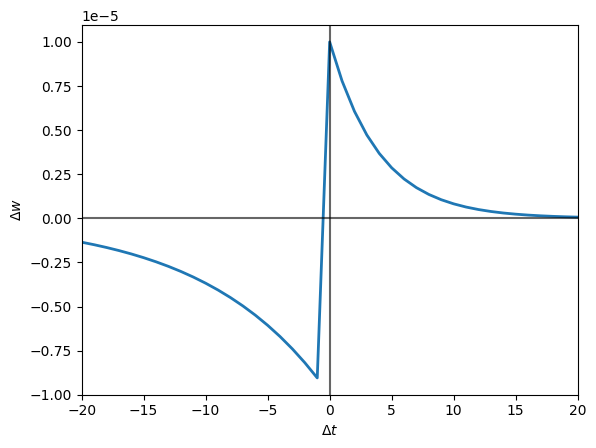

In [9]:
# Can visualize the function which the assistant will use. The parameters
# stdp_learning_rate and stdp_tau_combined will influence this!


# NEEDS TO BE RE-PLOTTED, just run again.
assistant.plot_stdp_curve()

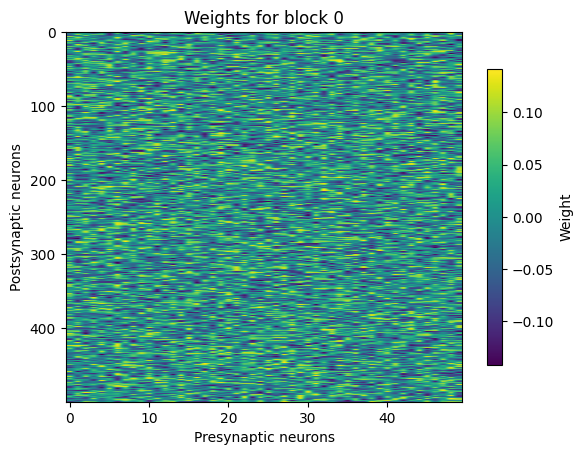

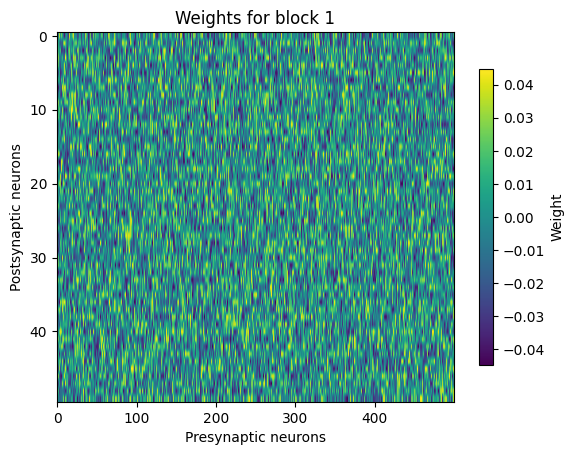

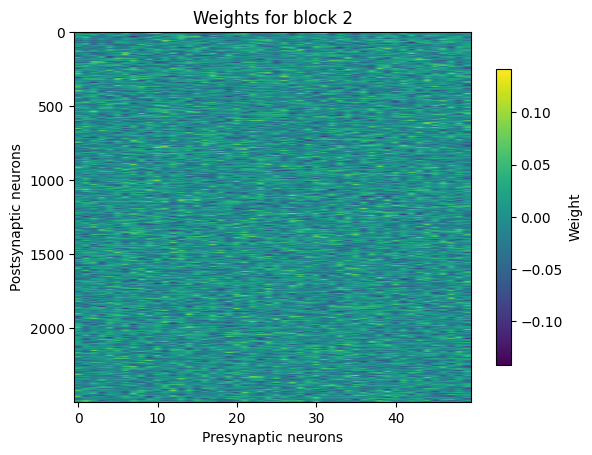

In [10]:
# Easy visualization of what's going on with the network weights
for i in range(len(layer_sizes)-1):
    hybrid_network.plot_weights(i)

# from Andrei - training script

## 1:50

In [5]:
# Creating the dataset
np.random.seed(0)

n_train = 5000 # 1,000,000 in the original paper
n_val = 1000 # 8192 in the original paper
n_prot = 20 # 200 prototypes in the original paper
n_class = 10 # 100 classes in the original paper


# TODO: choose appropriate layer sizes
layer_sizes = [50, 500, 50, 2500]

n_ors = layer_sizes[0] # 50 olfactory receptors
n_timepoints = 150 # Number of timepoints per sample in the dataset
batch_size = 256

# The "prototype smells" for each class; the prototype closest to the
# smell in euclidean space determines the smell's class (BUT NOT DIRECTLY)
prototypes = np.random.uniform(0,1, (n_prot, n_ors)).astype(np.float32)

train_x = np.random.uniform(0,1, (n_train, n_ors)).astype(np.float32)
val_x = np.random.uniform(0,1, (n_val, n_ors)).astype(np.float32)

def get_labels(prototypes, odors):
    ''' The prototype with the shortest Euclidean distance to each smell
        becomes the smell's label'''
    # Calculating euclidean distances for each odor, across all prototypes
    dist = euclidean_distances(prototypes, odors)
    # Finding the prototype with the minimum distance to each smell, and partitioning
    # into the ACTUAL CLASS (just assume they're put next to each other)
    return np.argmin(dist, axis=0)//2

train_y = get_labels(prototypes, train_x).astype(np.int32)
val_y = get_labels(prototypes, val_x).astype(np.int32)

# Stacking the input to 300 timepoints
train_x = train_x.transpose()
val_x = val_x.transpose()
train_x = np.repeat(train_x[:, np.newaxis, :], n_timepoints, axis=1)
val_x = np.repeat(val_x[:, np.newaxis, :], n_timepoints, axis=1)
train_x = torch.tensor(train_x)
val_x = torch.tensor(val_x)

class ORDataset(Dataset):
    """Dataset operating on olfactory receptors"""

    def __init__(self, input, labels):
        """
        Arguments:
            dataset (np.ndarray): the olfactory receptor dataset, in the shape
                of (n_ors, n_timepoints, n_samples)
        """
        self.input = input
        self.labels = labels

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.input[:,:,idx], self.labels[idx])

# # Saving datasets
# data_folder = os.path.join(os.getcwd(),'Data')
# os.makedirs(data_folder, exist_ok=True)

# save(os.path.join(data_folder, 'train_x'), train_x)
# save(os.path.join(data_folder, 'train_y'), train_y)
# save(os.path.join(data_folder, 'val_x'), val_x)
# save(os.path.join(data_folder, 'val_y'), val_y)


class HybridNetwork(torch.nn.Module):
    def __init__(self, layer_sizes,
                 n_class, stdp_learning_rate,
                 stdp_tau_combined, train_hybrid, burn_in=0):

        super(HybridNetwork, self).__init__()

        self.burn_in = burn_in
        self.stdp_learning_rate = stdp_learning_rate
        self.stdp_tau_combined = stdp_tau_combined
        self.layer_sizes = layer_sizes
        self.train_hybrid = train_hybrid

        # Input neuron parameters, threshold set to 1 as per course guidelines
        input_neuron_parameters = {
            'threshold': 1.,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }
        # Default values in SLAYER and DECOLLE notebooks
        neuron_parameters = {
            'threshold': 1.25,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }

        # Defining layers. Input layer defined separately to make dataset work.
        blocks = [slayer.block.cuba.Dense(
            input_neuron_parameters, layer_sizes[0], layer_sizes[1], weight_norm=False)]

        for i in range(1, len(layer_sizes)-1):
            blocks.append(slayer.block.cuba.Dense(
                neuron_parameters, layer_sizes[i],
                layer_sizes[i+1], weight_norm=False))

        self.blocks = torch.nn.ModuleList(blocks)

        # Removing gradient dependence for the STDP block if training in hybrid
        # mode.
        if self.train_hybrid:
            self.blocks[-1].synapse.weight.requires_grad=False

        # Defining random readouts for each layer except the input.

        readout_layers = []
        for layer_size in self.layer_sizes[1:]:
                readout_layers.append(torch.nn.Linear(layer_size, n_class, bias=False))
        self.readout_layers = torch.nn.ModuleList(readout_layers)

        # If training in hybrid mode, last readout layer needs gradient
        # computation, whereas none of the readouts need this with
        # standard DECOLLE
        for readout_layer in self.readout_layers:
            readout_layer.weight.requires_grad = False
        if self.train_hybrid:
            self.readout_layers[-1].weight.requires_grad = True

    def forward(self, spike):
        # First we pass the input through all of the layers and get the
        # corresponding output at each layer, then we iterate through
        # these layers' linear readout layers as well. Readout layers
        # are returned for all layers, with the pre-specified gradient
        # dependencies determining what happens when these readouts are used
        # for gradient descent.

        spike.requires_grad_()
        all_spikes = [] # all spikes within the model
        readouts = []
        voltages = []
        spike_counts = []

        for i, layer in enumerate(self.blocks):
            # Getting voltage at each postsynaptic neuron corresponding to input.
            # Since gradient updates are computed locally, input spikes to each
            # layer are detached from previous computations.
            z = layer.synapse(spike.detach())
            _, voltage = layer.neuron.dynamics(z)
            # Getting the spikes that result from the voltage at these neurons
            spike = layer.neuron.spike(voltage)

            # If training in hybrid mode, we don't want any gradient accumulation
            # for the spikes created within the last block
            if self.train_hybrid and i == 2:
                all_spikes.append(spike.detach())
            else:
                all_spikes.append(spike)

            voltages.append(voltage)
            spike_counts.append(torch.mean(spike.detach()))

        for readout_layer, spike in zip(self.readout_layers, all_spikes):
            # Getting a linear readout of each layer
            readout = []
            for t in range(spike.shape[-1]):
                readout.append(readout_layer(spike[..., t]))
            readouts.append(torch.stack(readout, dim=-1))

        return all_spikes, readouts, voltages, spike_counts

    def reset_(self):
        # Resetting the state of the network
        for layer in self.blocks:
            layer.neuron.current_state[:] = 0
            layer.neuron.voltage_state[:] = 0

    def init_state(self, inputs, burn_in=None):
        # Resets the network state, and applies an initial burn-in period
        # by passing the first few timepoints of the input through the network
        self.reset_()
        if burn_in is None:
            burn_in = self.burn_in
        self.forward(inputs[..., :burn_in])

        return inputs[..., :burn_in]

    def plot_weights(self, block_idx):
        plt.figure()
        layer_params = self.blocks[block_idx].synapse.weight.data
        weight_matrix = np.squeeze(layer_params.numpy())
        plt.imshow(weight_matrix, aspect='auto')
        plt.colorbar(shrink = 0.8, label = 'Weight')
        plt.title(f'Weights for block {block_idx}')
        plt.xlabel('Presynaptic neurons')
        plt.ylabel('Postsynaptic neurons')

    def print_weights(self, block_idx):
        print(np.squeeze(self.blocks[block_idx].synapse.weight.data.numpy()))


# Initializing everything
trained_folder = 'dummy_Trained'
os.makedirs(trained_folder, exist_ok=True)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

stdp_learning_rate = 0.00001
stdp_tau_combined = -2

hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_learning_rate,
    stdp_tau_combined, train_hybrid=True, burn_in=50).to(device)

error = DECOLLELoss(torch.nn.SmoothL1Loss, reduction='mean')
optimizer = torch.optim.Adam(hybrid_network.parameters(), lr=0.0001)

stats = slayer.utils.LearningStats()
assistant = HybridAssistant(hybrid_network, error, optimizer, stats,
                             classifier=slayer.classifier.Rate.predict, count_log=True)


# TODO: pick model name
NAME_MODEL = "1to50_30epochs"

trained_folder = f"fixed_CHECKPOINTS_{NAME_MODEL}"
os.makedirs(trained_folder, exist_ok=True)

# TODO: pick number epochs
epochs = 30

for epoch_i, epoch in enumerate(range(epochs)):

    # Training
    train_iter = iter(training_loader)
    for (inputs, label) in tqdm(train_iter):
        output, count = assistant.train_hybrid(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class),
            ignore_zeros=False)   # CRUCIAL PARAMETER: IGNORE_ZEROS

    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    # Testing
    test_iter = iter(testing_loader)
    for (inputs, label) in tqdm(test_iter):
        output, count = assistant.test(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class))
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    # saving network every epoch
    torch.save(hybrid_network.state_dict(), trained_folder + f'/network_{NAME_MODEL}_epoch_{epoch_i}.pt')


100%|██████████| 20/20 [06:59<00:00, 20.95s/it]


[Epoch  0/30] Train loss =     9.07020                          accuracy = 0.29620 

100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


[Epoch  0/30] Train loss =     9.07020                          accuracy = 0.29620  | Test  loss =     7.06449                          accuracy = 0.37300 

100%|██████████| 20/20 [06:40<00:00, 20.01s/it]


[Epoch  1/30] Train loss =     7.78952                          accuracy = 0.36160  | Test  loss =     7.06449                          accuracy = 0.37300 

100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


[Epoch  1/30] Train loss =     7.78952                          accuracy = 0.36160  | Test  loss =     6.90310                          accuracy = 0.39450 

100%|██████████| 20/20 [06:42<00:00, 20.11s/it]


[Epoch  2/30] Train loss =     7.28351                          accuracy = 0.39793  | Test  loss =     6.90310                          accuracy = 0.39450 

100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


[Epoch  2/30] Train loss =     7.28351                          accuracy = 0.39793  | Test  loss =     6.86530                          accuracy = 0.40333 

100%|██████████| 20/20 [06:38<00:00, 19.92s/it]


[Epoch  3/30] Train loss =     6.99239                          accuracy = 0.42425  | Test  loss =     6.86530                          accuracy = 0.40333 

100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


[Epoch  3/30] Train loss =     6.99239                          accuracy = 0.42425  | Test  loss =     6.78527                          accuracy = 0.41700 

100%|██████████| 20/20 [06:41<00:00, 20.06s/it]


[Epoch  4/30] Train loss =     6.79428                          accuracy = 0.44404  | Test  loss =     6.78527                          accuracy = 0.41700 

100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


[Epoch  4/30] Train loss =     6.79428                          accuracy = 0.44404  | Test  loss =     6.76230                          accuracy = 0.41680 

100%|██████████| 20/20 [06:42<00:00, 20.14s/it]


[Epoch  5/30] Train loss =     6.64349                          accuracy = 0.46003  | Test  loss =     6.76230                          accuracy = 0.41680 

100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


[Epoch  5/30] Train loss =     6.64349                          accuracy = 0.46003  | Test  loss =     6.70866                          accuracy = 0.42750 

100%|██████████| 20/20 [06:46<00:00, 20.34s/it]


[Epoch  6/30] Train loss =     6.51928                          accuracy = 0.47460  | Test  loss =     6.70866                          accuracy = 0.42750 

100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


[Epoch  6/30] Train loss =     6.51928                          accuracy = 0.47460  | Test  loss =     6.66303                          accuracy = 0.43471 

100%|██████████| 20/20 [06:46<00:00, 20.32s/it]


[Epoch  7/30] Train loss =     6.41532                          accuracy = 0.48700  | Test  loss =     6.66303                          accuracy = 0.43471 

100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


[Epoch  7/30] Train loss =     6.41532                          accuracy = 0.48700  | Test  loss =     6.61773                          accuracy = 0.44450 

100%|██████████| 20/20 [06:47<00:00, 20.38s/it]


[Epoch  8/30] Train loss =     6.32438                          accuracy = 0.49951  | Test  loss =     6.61773                          accuracy = 0.44450 

100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


[Epoch  8/30] Train loss =     6.32438                          accuracy = 0.49951  | Test  loss =     6.59975                          accuracy = 0.44500 

100%|██████████| 20/20 [06:48<00:00, 20.41s/it]


[Epoch  9/30] Train loss =     6.24311                          accuracy = 0.50976  | Test  loss =     6.59975                          accuracy = 0.44500 

100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


[Epoch  9/30] Train loss =     6.24311                          accuracy = 0.50976  | Test  loss =     6.56288                          accuracy = 0.45260 

100%|██████████| 20/20 [06:48<00:00, 20.44s/it]


[Epoch 10/30] Train loss =     6.17084                          accuracy = 0.51905  | Test  loss =     6.56288                          accuracy = 0.45260 

100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


[Epoch 10/30] Train loss =     6.17084                          accuracy = 0.51905  | Test  loss =     6.52812                          accuracy = 0.45873 

100%|██████████| 20/20 [39:22<00:00, 118.13s/it]


[Epoch 11/30] Train loss =     6.10369                          accuracy = 0.52803  | Test  loss =     6.52812                          accuracy = 0.45873 

100%|██████████| 4/4 [00:13<00:00,  3.26s/it]


[Epoch 11/30] Train loss =     6.10369                          accuracy = 0.52803  | Test  loss =     6.49710                          accuracy = 0.46408 

100%|██████████| 20/20 [06:57<00:00, 20.86s/it]


[Epoch 12/30] Train loss =     6.04056                          accuracy = 0.53665  | Test  loss =     6.49710                          accuracy = 0.46408 

100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


[Epoch 12/30] Train loss =     6.04056                          accuracy = 0.53665  | Test  loss =     6.47025                          accuracy = 0.46908 

100%|██████████| 20/20 [06:58<00:00, 20.94s/it]


[Epoch 13/30] Train loss =     5.98305                          accuracy = 0.54420  | Test  loss =     6.47025                          accuracy = 0.46908 

100%|██████████| 4/4 [00:12<00:00,  3.08s/it]


[Epoch 13/30] Train loss =     5.98305                          accuracy = 0.54420  | Test  loss =     6.43863                          accuracy = 0.47557 

100%|██████████| 20/20 [07:00<00:00, 21.03s/it]


[Epoch 14/30] Train loss =     5.93188                          accuracy = 0.55028  | Test  loss =     6.43863                          accuracy = 0.47557 

100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


[Epoch 14/30] Train loss =     5.93188                          accuracy = 0.55028  | Test  loss =     6.41451                          accuracy = 0.48220 

100%|██████████| 20/20 [14:49<00:00, 44.50s/it]  


[Epoch 15/30] Train loss =     5.88443                          accuracy = 0.55614  | Test  loss =     6.41451                          accuracy = 0.48220 

100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


[Epoch 15/30] Train loss =     5.88443                          accuracy = 0.55614  | Test  loss =     6.38891                          accuracy = 0.48606 

100%|██████████| 20/20 [06:45<00:00, 20.29s/it]


[Epoch 16/30] Train loss =     5.84093                          accuracy = 0.56189  | Test  loss =     6.38891                          accuracy = 0.48606 

100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


[Epoch 16/30] Train loss =     5.84093                          accuracy = 0.56189  | Test  loss =     6.36405                          accuracy = 0.49065 

100%|██████████| 20/20 [06:41<00:00, 20.05s/it]


[Epoch 17/30] Train loss =     5.80002                          accuracy = 0.56708  | Test  loss =     6.36405                          accuracy = 0.49065 

100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


[Epoch 17/30] Train loss =     5.80002                          accuracy = 0.56708  | Test  loss =     6.34133                          accuracy = 0.49422 

100%|██████████| 20/20 [1:10:42<00:00, 212.15s/it]


[Epoch 18/30] Train loss =     5.76238                          accuracy = 0.57154  | Test  loss =     6.34133                          accuracy = 0.49422 

100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


[Epoch 18/30] Train loss =     5.76238                          accuracy = 0.57154  | Test  loss =     6.32167                          accuracy = 0.49768 

100%|██████████| 20/20 [10:59<00:00, 32.95s/it]


[Epoch 19/30] Train loss =     5.72724                          accuracy = 0.57561  | Test  loss =     6.32167                          accuracy = 0.49768 

100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


[Epoch 19/30] Train loss =     5.72724                          accuracy = 0.57561  | Test  loss =     6.30725                          accuracy = 0.50090 

100%|██████████| 20/20 [07:05<00:00, 21.28s/it]


[Epoch 20/30] Train loss =     5.69527                          accuracy = 0.57924  | Test  loss =     6.30725                          accuracy = 0.50090 

100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


[Epoch 20/30] Train loss =     5.69527                          accuracy = 0.57924  | Test  loss =     6.28768                          accuracy = 0.50381 

100%|██████████| 20/20 [07:01<00:00, 21.09s/it]


[Epoch 21/30] Train loss =     5.66491                          accuracy = 0.58244  | Test  loss =     6.28768                          accuracy = 0.50381 

100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


[Epoch 21/30] Train loss =     5.66491                          accuracy = 0.58244  | Test  loss =     6.26960                          accuracy = 0.50650 

100%|██████████| 20/20 [06:40<00:00, 20.03s/it]


[Epoch 22/30] Train loss =     5.63780                          accuracy = 0.58502  | Test  loss =     6.26960                          accuracy = 0.50650 

100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


[Epoch 22/30] Train loss =     5.63780                          accuracy = 0.58502  | Test  loss =     6.25570                          accuracy = 0.50813 

100%|██████████| 20/20 [06:50<00:00, 20.53s/it]


[Epoch 23/30] Train loss =     5.61204                          accuracy = 0.58765  | Test  loss =     6.25570                          accuracy = 0.50813 

100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


[Epoch 23/30] Train loss =     5.61204                          accuracy = 0.58765  | Test  loss =     6.24313                          accuracy = 0.50862 

100%|██████████| 20/20 [06:39<00:00, 19.95s/it]


[Epoch 24/30] Train loss =     5.58887                          accuracy = 0.58958  | Test  loss =     6.24313                          accuracy = 0.50862 

100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


[Epoch 24/30] Train loss =     5.58887                          accuracy = 0.58958  | Test  loss =     6.23118                          accuracy = 0.50952 

100%|██████████| 20/20 [06:52<00:00, 20.62s/it]


[Epoch 25/30] Train loss =     5.56611                          accuracy = 0.59108  | Test  loss =     6.23118                          accuracy = 0.50952 

100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


[Epoch 25/30] Train loss =     5.56611                          accuracy = 0.59108  | Test  loss =     6.22373                          accuracy = 0.51123 

100%|██████████| 20/20 [06:31<00:00, 19.58s/it]


[Epoch 26/30] Train loss =     5.54541                          accuracy = 0.59221  | Test  loss =     6.22373                          accuracy = 0.51123 

100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


[Epoch 26/30] Train loss =     5.54541                          accuracy = 0.59221  | Test  loss =     6.21371                          accuracy = 0.51130 

100%|██████████| 20/20 [06:35<00:00, 19.77s/it]


[Epoch 27/30] Train loss =     5.52655                          accuracy = 0.59340  | Test  loss =     6.21371                          accuracy = 0.51130 

100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


[Epoch 27/30] Train loss =     5.52655                          accuracy = 0.59340  | Test  loss =     6.20995                          accuracy = 0.51000 

100%|██████████| 20/20 [06:30<00:00, 19.53s/it]


[Epoch 28/30] Train loss =     5.50906                          accuracy = 0.59418  | Test  loss =     6.20995                          accuracy = 0.51000 

100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


[Epoch 28/30] Train loss =     5.50906                          accuracy = 0.59418  | Test  loss =     6.20563                          accuracy = 0.50938 

100%|██████████| 20/20 [06:33<00:00, 19.68s/it]


[Epoch 29/30] Train loss =     5.49283                          accuracy = 0.59478  | Test  loss =     6.20563                          accuracy = 0.50938 

100%|██████████| 4/4 [00:10<00:00,  2.60s/it]

[Epoch 29/30] Train loss =     5.49283                          accuracy = 0.59478  | Test  loss =     6.19748                          accuracy = 0.50820 

# from Andrei - training stripts for all conditions

## 1:1

In [ ]:
# Creating the dataset
np.random.seed(0)

n_train = 5000 # 1,000,000 in the original paper
n_val = 1000 # 8192 in the original paper
n_prot = 20 # 200 prototypes in the original paper
n_class = 10 # 100 classes in the original paper


# TODO: choose appropriate layer sizes
layer_sizes = [50, 500, 50, 50]

n_ors = layer_sizes[0] # 50 olfactory receptors
n_timepoints = 150 # Number of timepoints per sample in the dataset
batch_size = 256

# The "prototype smells" for each class; the prototype closest to the
# smell in euclidean space determines the smell's class (BUT NOT DIRECTLY)
prototypes = np.random.uniform(0,1, (n_prot, n_ors)).astype(np.float32)

train_x = np.random.uniform(0,1, (n_train, n_ors)).astype(np.float32)
val_x = np.random.uniform(0,1, (n_val, n_ors)).astype(np.float32)

def get_labels(prototypes, odors):
    ''' The prototype with the shortest Euclidean distance to each smell
        becomes the smell's label'''
    # Calculating euclidean distances for each odor, across all prototypes
    dist = euclidean_distances(prototypes, odors)
    # Finding the prototype with the minimum distance to each smell, and partitioning
    # into the ACTUAL CLASS (just assume they're put next to each other)
    return np.argmin(dist, axis=0)//2

train_y = get_labels(prototypes, train_x).astype(np.int32)
val_y = get_labels(prototypes, val_x).astype(np.int32)

# Stacking the input to 300 timepoints
train_x = train_x.transpose()
val_x = val_x.transpose()
train_x = np.repeat(train_x[:, np.newaxis, :], n_timepoints, axis=1)
val_x = np.repeat(val_x[:, np.newaxis, :], n_timepoints, axis=1)
train_x = torch.tensor(train_x)
val_x = torch.tensor(val_x)

class ORDataset(Dataset):
    """Dataset operating on olfactory receptors"""

    def __init__(self, input, labels):
        """
        Arguments:
            dataset (np.ndarray): the olfactory receptor dataset, in the shape
                of (n_ors, n_timepoints, n_samples)
        """
        self.input = input
        self.labels = labels

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.input[:,:,idx], self.labels[idx])

# # Saving datasets
# data_folder = os.path.join(os.getcwd(),'Data')
# os.makedirs(data_folder, exist_ok=True)

# save(os.path.join(data_folder, 'train_x'), train_x)
# save(os.path.join(data_folder, 'train_y'), train_y)
# save(os.path.join(data_folder, 'val_x'), val_x)
# save(os.path.join(data_folder, 'val_y'), val_y)


class HybridNetwork(torch.nn.Module):
    def __init__(self, layer_sizes,
                 n_class, stdp_learning_rate,
                 stdp_tau_combined, train_hybrid, burn_in=0):

        super(HybridNetwork, self).__init__()

        self.burn_in = burn_in
        self.stdp_learning_rate = stdp_learning_rate
        self.stdp_tau_combined = stdp_tau_combined
        self.layer_sizes = layer_sizes
        self.train_hybrid = train_hybrid

        # Input neuron parameters, threshold set to 1 as per course guidelines
        input_neuron_parameters = {
            'threshold': 1.,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }
        # Default values in SLAYER and DECOLLE notebooks
        neuron_parameters = {
            'threshold': 1.25,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }

        # Defining layers. Input layer defined separately to make dataset work.
        blocks = [slayer.block.cuba.Dense(
            input_neuron_parameters, layer_sizes[0], layer_sizes[1], weight_norm=False)]

        for i in range(1, len(layer_sizes)-1):
            blocks.append(slayer.block.cuba.Dense(
                neuron_parameters, layer_sizes[i],
                layer_sizes[i+1], weight_norm=False))

        self.blocks = torch.nn.ModuleList(blocks)

        # Removing gradient dependence for the STDP block if training in hybrid
        # mode.
        if self.train_hybrid:
            self.blocks[-1].synapse.weight.requires_grad=False

        # Defining random readouts for each layer except the input.

        readout_layers = []
        for layer_size in self.layer_sizes[1:]:
                readout_layers.append(torch.nn.Linear(layer_size, n_class, bias=False))
        self.readout_layers = torch.nn.ModuleList(readout_layers)

        # If training in hybrid mode, last readout layer needs gradient
        # computation, whereas none of the readouts need this with
        # standard DECOLLE
        for readout_layer in self.readout_layers:
            readout_layer.weight.requires_grad = False
        if self.train_hybrid:
            self.readout_layers[-1].weight.requires_grad = True

    def forward(self, spike):
        # First we pass the input through all of the layers and get the
        # corresponding output at each layer, then we iterate through
        # these layers' linear readout layers as well. Readout layers
        # are returned for all layers, with the pre-specified gradient
        # dependencies determining what happens when these readouts are used
        # for gradient descent.

        spike.requires_grad_()
        all_spikes = [] # all spikes within the model
        readouts = []
        voltages = []
        spike_counts = []

        for i, layer in enumerate(self.blocks):
            # Getting voltage at each postsynaptic neuron corresponding to input.
            # Since gradient updates are computed locally, input spikes to each
            # layer are detached from previous computations.
            z = layer.synapse(spike.detach())
            _, voltage = layer.neuron.dynamics(z)
            # Getting the spikes that result from the voltage at these neurons
            spike = layer.neuron.spike(voltage)

            # If training in hybrid mode, we don't want any gradient accumulation
            # for the spikes created within the last block
            if self.train_hybrid and i == 2:
                all_spikes.append(spike.detach())
            else:
                all_spikes.append(spike)

            voltages.append(voltage)
            spike_counts.append(torch.mean(spike.detach()))

        for readout_layer, spike in zip(self.readout_layers, all_spikes):
            # Getting a linear readout of each layer
            readout = []
            for t in range(spike.shape[-1]):
                readout.append(readout_layer(spike[..., t]))
            readouts.append(torch.stack(readout, dim=-1))

        return all_spikes, readouts, voltages, spike_counts

    def reset_(self):
        # Resetting the state of the network
        for layer in self.blocks:
            layer.neuron.current_state[:] = 0
            layer.neuron.voltage_state[:] = 0

    def init_state(self, inputs, burn_in=None):
        # Resets the network state, and applies an initial burn-in period
        # by passing the first few timepoints of the input through the network
        self.reset_()
        if burn_in is None:
            burn_in = self.burn_in
        self.forward(inputs[..., :burn_in])

        return inputs[..., :burn_in]

    def plot_weights(self, block_idx):
        plt.figure()
        layer_params = self.blocks[block_idx].synapse.weight.data
        weight_matrix = np.squeeze(layer_params.numpy())
        plt.imshow(weight_matrix, aspect='auto')
        plt.colorbar(shrink = 0.8, label = 'Weight')
        plt.title(f'Weights for block {block_idx}')
        plt.xlabel('Presynaptic neurons')
        plt.ylabel('Postsynaptic neurons')

    def print_weights(self, block_idx):
        print(np.squeeze(self.blocks[block_idx].synapse.weight.data.numpy()))


# Initializing everything
trained_folder = 'dummy_Trained'
os.makedirs(trained_folder, exist_ok=True)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

stdp_learning_rate = 0.00001
stdp_tau_combined = -2

hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_learning_rate,
    stdp_tau_combined, train_hybrid=True, burn_in=50).to(device)

error = DECOLLELoss(torch.nn.SmoothL1Loss, reduction='mean')
optimizer = torch.optim.Adam(hybrid_network.parameters(), lr=0.0001)

stats = slayer.utils.LearningStats()
assistant = HybridAssistant(hybrid_network, error, optimizer, stats,
                             classifier=slayer.classifier.Rate.predict, count_log=True)





# TODO: pick model name
NAME_MODEL = "1to1_30epochs"

trained_folder = f"CHECKPOINTS_{NAME_MODEL}"
os.makedirs(trained_folder, exist_ok=True)

# TODO: pick number epochs
epochs = 30

for epoch_i, epoch in enumerate(range(epochs)):

    # Training
    train_iter = iter(training_loader)
    for (inputs, label) in tqdm(train_iter):
        output, count = assistant.train_hybrid(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class),
            ignore_zeros=False)   # CRUCIAL PARAMETER: IGNORE_ZEROS

    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    # Testing
    test_iter = iter(testing_loader)
    for (inputs, label) in tqdm(test_iter):
        output, count = assistant.test(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class))
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    # saving network every epoch
    torch.save(hybrid_network.state_dict(), trained_folder + f'/network_{NAME_MODEL}_epoch_{epoch_i}.pt')


    stats.update()
    stats.save(path= trained_folder+ "/")

## 1:10

In [ ]:
# Creating the dataset
np.random.seed(0)

n_train = 5000 # 1,000,000 in the original paper
n_val = 1000 # 8192 in the original paper
n_prot = 20 # 200 prototypes in the original paper
n_class = 10 # 100 classes in the original paper

# TODO: choose appropriate layer sizes
layer_sizes = [50, 500, 50, 500]

n_ors = layer_sizes[0] # 50 olfactory receptors
n_timepoints = 150 # Number of timepoints per sample in the dataset
batch_size = 256

# The "prototype smells" for each class; the prototype closest to the
# smell in euclidean space determines the smell's class (BUT NOT DIRECTLY)
prototypes = np.random.uniform(0,1, (n_prot, n_ors)).astype(np.float32)

train_x = np.random.uniform(0,1, (n_train, n_ors)).astype(np.float32)
val_x = np.random.uniform(0,1, (n_val, n_ors)).astype(np.float32)

def get_labels(prototypes, odors):
    ''' The prototype with the shortest Euclidean distance to each smell
        becomes the smell's label'''
    # Calculating euclidean distances for each odor, across all prototypes
    dist = euclidean_distances(prototypes, odors)
    # Finding the prototype with the minimum distance to each smell, and partitioning
    # into the ACTUAL CLASS (just assume they're put next to each other)
    return np.argmin(dist, axis=0)//2

train_y = get_labels(prototypes, train_x).astype(np.int32)
val_y = get_labels(prototypes, val_x).astype(np.int32)

# Stacking the input to 300 timepoints
train_x = train_x.transpose()
val_x = val_x.transpose()
train_x = np.repeat(train_x[:, np.newaxis, :], n_timepoints, axis=1)
val_x = np.repeat(val_x[:, np.newaxis, :], n_timepoints, axis=1)
train_x = torch.tensor(train_x)
val_x = torch.tensor(val_x)

class ORDataset(Dataset):
    """Dataset operating on olfactory receptors"""

    def __init__(self, input, labels):
        """
        Arguments:
            dataset (np.ndarray): the olfactory receptor dataset, in the shape
                of (n_ors, n_timepoints, n_samples)
        """
        self.input = input
        self.labels = labels

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.input[:,:,idx], self.labels[idx])

# # Saving datasets
# data_folder = os.path.join(os.getcwd(),'Data')
# os.makedirs(data_folder, exist_ok=True)

# save(os.path.join(data_folder, 'train_x'), train_x)
# save(os.path.join(data_folder, 'train_y'), train_y)
# save(os.path.join(data_folder, 'val_x'), val_x)
# save(os.path.join(data_folder, 'val_y'), val_y)


class HybridNetwork(torch.nn.Module):
    def __init__(self, layer_sizes,
                 n_class, stdp_learning_rate,
                 stdp_tau_combined, train_hybrid, burn_in=0):

        super(HybridNetwork, self).__init__()

        self.burn_in = burn_in
        self.stdp_learning_rate = stdp_learning_rate
        self.stdp_tau_combined = stdp_tau_combined
        self.layer_sizes = layer_sizes
        self.train_hybrid = train_hybrid

        # Input neuron parameters, threshold set to 1 as per course guidelines
        input_neuron_parameters = {
            'threshold': 1.,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }
        # Default values in SLAYER and DECOLLE notebooks
        neuron_parameters = {
            'threshold': 1.25,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }

        # Defining layers. Input layer defined separately to make dataset work.
        blocks = [slayer.block.cuba.Dense(
            input_neuron_parameters, layer_sizes[0], layer_sizes[1], weight_norm=False)]

        for i in range(1, len(layer_sizes)-1):
            blocks.append(slayer.block.cuba.Dense(
                neuron_parameters, layer_sizes[i],
                layer_sizes[i+1], weight_norm=False))

        self.blocks = torch.nn.ModuleList(blocks)

        # Removing gradient dependence for the STDP block if training in hybrid
        # mode.
        if self.train_hybrid:
            self.blocks[-1].synapse.weight.requires_grad=False

        # Defining random readouts for each layer except the input.

        readout_layers = []
        for layer_size in self.layer_sizes[1:]:
                readout_layers.append(torch.nn.Linear(layer_size, n_class, bias=False))
        self.readout_layers = torch.nn.ModuleList(readout_layers)

        # If training in hybrid mode, last readout layer needs gradient
        # computation, whereas none of the readouts need this with
        # standard DECOLLE
        for readout_layer in self.readout_layers:
            readout_layer.weight.requires_grad = False
        if self.train_hybrid:
            self.readout_layers[-1].weight.requires_grad = True

    def forward(self, spike):
        # First we pass the input through all of the layers and get the
        # corresponding output at each layer, then we iterate through
        # these layers' linear readout layers as well. Readout layers
        # are returned for all layers, with the pre-specified gradient
        # dependencies determining what happens when these readouts are used
        # for gradient descent.

        spike.requires_grad_()
        all_spikes = [] # all spikes within the model
        readouts = []
        voltages = []
        spike_counts = []

        for i, layer in enumerate(self.blocks):
            # Getting voltage at each postsynaptic neuron corresponding to input.
            # Since gradient updates are computed locally, input spikes to each
            # layer are detached from previous computations.
            z = layer.synapse(spike.detach())
            _, voltage = layer.neuron.dynamics(z)
            # Getting the spikes that result from the voltage at these neurons
            spike = layer.neuron.spike(voltage)

            # If training in hybrid mode, we don't want any gradient accumulation
            # for the spikes created within the last block
            if self.train_hybrid and i == 2:
                all_spikes.append(spike.detach())
            else:
                all_spikes.append(spike)

            voltages.append(voltage)
            spike_counts.append(torch.mean(spike.detach()))

        for readout_layer, spike in zip(self.readout_layers, all_spikes):
            # Getting a linear readout of each layer
            readout = []
            for t in range(spike.shape[-1]):
                readout.append(readout_layer(spike[..., t]))
            readouts.append(torch.stack(readout, dim=-1))

        return all_spikes, readouts, voltages, spike_counts

    def reset_(self):
        # Resetting the state of the network
        for layer in self.blocks:
            layer.neuron.current_state[:] = 0
            layer.neuron.voltage_state[:] = 0

    def init_state(self, inputs, burn_in=None):
        # Resets the network state, and applies an initial burn-in period
        # by passing the first few timepoints of the input through the network
        self.reset_()
        if burn_in is None:
            burn_in = self.burn_in
        self.forward(inputs[..., :burn_in])

        return inputs[..., :burn_in]

    def plot_weights(self, block_idx):
        plt.figure()
        layer_params = self.blocks[block_idx].synapse.weight.data
        weight_matrix = np.squeeze(layer_params.numpy())
        plt.imshow(weight_matrix, aspect='auto')
        plt.colorbar(shrink = 0.8, label = 'Weight')
        plt.title(f'Weights for block {block_idx}')
        plt.xlabel('Presynaptic neurons')
        plt.ylabel('Postsynaptic neurons')

    def print_weights(self, block_idx):
        print(np.squeeze(self.blocks[block_idx].synapse.weight.data.numpy()))


# Initializing everything
trained_folder = 'dummy_Trained'
os.makedirs(trained_folder, exist_ok=True)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

stdp_learning_rate = 0.00001
stdp_tau_combined = -2

hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_learning_rate,
    stdp_tau_combined, train_hybrid=True, burn_in=50).to(device)

error = DECOLLELoss(torch.nn.SmoothL1Loss, reduction='mean')
optimizer = torch.optim.Adam(hybrid_network.parameters(), lr=0.0001)

stats = slayer.utils.LearningStats()
assistant = HybridAssistant(hybrid_network, error, optimizer, stats,
                             classifier=slayer.classifier.Rate.predict, count_log=True)


# TODO: pick model name
NAME_MODEL = "1to10_30epochs"

trained_folder = f"CHECKPOINTS_{NAME_MODEL}"
os.makedirs(trained_folder, exist_ok=True)

# TODO: pick number epochs
epochs = 30

for epoch_i, epoch in enumerate(range(epochs)):

    # Training
    train_iter = iter(training_loader)
    for (inputs, label) in tqdm(train_iter):
        output, count = assistant.train_hybrid(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class),
            ignore_zeros=False)   # CRUCIAL PARAMETER: IGNORE_ZEROS

    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    # Testing
    test_iter = iter(testing_loader)
    for (inputs, label) in tqdm(test_iter):
        output, count = assistant.test(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class))
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    # saving network every epoch
    torch.save(hybrid_network.state_dict(), trained_folder + f'/network_{NAME_MODEL}_epoch_{epoch_i}.pt')


## 1:100

In [6]:
# Creating the dataset
np.random.seed(0)

n_train = 5000 # 1,000,000 in the original paper
n_val = 1000 # 8192 in the original paper
n_prot = 20 # 200 prototypes in the original paper
n_class = 10 # 100 classes in the original paper


# TODO: choose appropriate layer sizes
layer_sizes = [50, 500, 50, 5000]

n_ors = layer_sizes[0] # 50 olfactory receptors
n_timepoints = 150 # Number of timepoints per sample in the dataset
batch_size = 256

# The "prototype smells" for each class; the prototype closest to the
# smell in euclidean space determines the smell's class (BUT NOT DIRECTLY)
prototypes = np.random.uniform(0,1, (n_prot, n_ors)).astype(np.float32)

train_x = np.random.uniform(0,1, (n_train, n_ors)).astype(np.float32)
val_x = np.random.uniform(0,1, (n_val, n_ors)).astype(np.float32)

def get_labels(prototypes, odors):
    ''' The prototype with the shortest Euclidean distance to each smell
        becomes the smell's label'''
    # Calculating euclidean distances for each odor, across all prototypes
    dist = euclidean_distances(prototypes, odors)
    # Finding the prototype with the minimum distance to each smell, and partitioning
    # into the ACTUAL CLASS (just assume they're put next to each other)
    return np.argmin(dist, axis=0)//2

train_y = get_labels(prototypes, train_x).astype(np.int32)
val_y = get_labels(prototypes, val_x).astype(np.int32)

# Stacking the input to 300 timepoints
train_x = train_x.transpose()
val_x = val_x.transpose()
train_x = np.repeat(train_x[:, np.newaxis, :], n_timepoints, axis=1)
val_x = np.repeat(val_x[:, np.newaxis, :], n_timepoints, axis=1)
train_x = torch.tensor(train_x)
val_x = torch.tensor(val_x)

class ORDataset(Dataset):
    """Dataset operating on olfactory receptors"""

    def __init__(self, input, labels):
        """
        Arguments:
            dataset (np.ndarray): the olfactory receptor dataset, in the shape
                of (n_ors, n_timepoints, n_samples)
        """
        self.input = input
        self.labels = labels

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.input[:,:,idx], self.labels[idx])

# # Saving datasets
# data_folder = os.path.join(os.getcwd(),'Data')
# os.makedirs(data_folder, exist_ok=True)

# save(os.path.join(data_folder, 'train_x'), train_x)
# save(os.path.join(data_folder, 'train_y'), train_y)
# save(os.path.join(data_folder, 'val_x'), val_x)
# save(os.path.join(data_folder, 'val_y'), val_y)


class HybridNetwork(torch.nn.Module):
    def __init__(self, layer_sizes,
                 n_class, stdp_learning_rate,
                 stdp_tau_combined, train_hybrid, burn_in=0):

        super(HybridNetwork, self).__init__()

        self.burn_in = burn_in
        self.stdp_learning_rate = stdp_learning_rate
        self.stdp_tau_combined = stdp_tau_combined
        self.layer_sizes = layer_sizes
        self.train_hybrid = train_hybrid

        # Input neuron parameters, threshold set to 1 as per course guidelines
        input_neuron_parameters = {
            'threshold': 1.,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }
        # Default values in SLAYER and DECOLLE notebooks
        neuron_parameters = {
            'threshold': 1.25,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }

        # Defining layers. Input layer defined separately to make dataset work.
        blocks = [slayer.block.cuba.Dense(
            input_neuron_parameters, layer_sizes[0], layer_sizes[1], weight_norm=False)]

        for i in range(1, len(layer_sizes)-1):
            blocks.append(slayer.block.cuba.Dense(
                neuron_parameters, layer_sizes[i],
                layer_sizes[i+1], weight_norm=False))

        self.blocks = torch.nn.ModuleList(blocks)

        # Removing gradient dependence for the STDP block if training in hybrid
        # mode.
        if self.train_hybrid:
            self.blocks[-1].synapse.weight.requires_grad=False

        # Defining random readouts for each layer except the input.

        readout_layers = []
        for layer_size in self.layer_sizes[1:]:
                readout_layers.append(torch.nn.Linear(layer_size, n_class, bias=False))
        self.readout_layers = torch.nn.ModuleList(readout_layers)

        # If training in hybrid mode, last readout layer needs gradient
        # computation, whereas none of the readouts need this with
        # standard DECOLLE
        for readout_layer in self.readout_layers:
            readout_layer.weight.requires_grad = False
        if self.train_hybrid:
            self.readout_layers[-1].weight.requires_grad = True

    def forward(self, spike):
        # First we pass the input through all of the layers and get the
        # corresponding output at each layer, then we iterate through
        # these layers' linear readout layers as well. Readout layers
        # are returned for all layers, with the pre-specified gradient
        # dependencies determining what happens when these readouts are used
        # for gradient descent.

        spike.requires_grad_()
        all_spikes = [] # all spikes within the model
        readouts = []
        voltages = []
        spike_counts = []

        for i, layer in enumerate(self.blocks):
            # Getting voltage at each postsynaptic neuron corresponding to input.
            # Since gradient updates are computed locally, input spikes to each
            # layer are detached from previous computations.
            z = layer.synapse(spike.detach())
            _, voltage = layer.neuron.dynamics(z)
            # Getting the spikes that result from the voltage at these neurons
            spike = layer.neuron.spike(voltage)

            # If training in hybrid mode, we don't want any gradient accumulation
            # for the spikes created within the last block
            if self.train_hybrid and i == 2:
                all_spikes.append(spike.detach())
            else:
                all_spikes.append(spike)

            voltages.append(voltage)
            spike_counts.append(torch.mean(spike.detach()))

        for readout_layer, spike in zip(self.readout_layers, all_spikes):
            # Getting a linear readout of each layer
            readout = []
            for t in range(spike.shape[-1]):
                readout.append(readout_layer(spike[..., t]))
            readouts.append(torch.stack(readout, dim=-1))

        return all_spikes, readouts, voltages, spike_counts

    def reset_(self):
        # Resetting the state of the network
        for layer in self.blocks:
            layer.neuron.current_state[:] = 0
            layer.neuron.voltage_state[:] = 0

    def init_state(self, inputs, burn_in=None):
        # Resets the network state, and applies an initial burn-in period
        # by passing the first few timepoints of the input through the network
        self.reset_()
        if burn_in is None:
            burn_in = self.burn_in
        self.forward(inputs[..., :burn_in])

        return inputs[..., :burn_in]

    def plot_weights(self, block_idx):
        plt.figure()
        layer_params = self.blocks[block_idx].synapse.weight.data
        weight_matrix = np.squeeze(layer_params.numpy())
        plt.imshow(weight_matrix, aspect='auto')
        plt.colorbar(shrink = 0.8, label = 'Weight')
        plt.title(f'Weights for block {block_idx}')
        plt.xlabel('Presynaptic neurons')
        plt.ylabel('Postsynaptic neurons')

    def print_weights(self, block_idx):
        print(np.squeeze(self.blocks[block_idx].synapse.weight.data.numpy()))


# Initializing everything
trained_folder = 'dummy_Trained'
os.makedirs(trained_folder, exist_ok=True)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

stdp_learning_rate = 0.00001
stdp_tau_combined = -2

hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_learning_rate,
    stdp_tau_combined, train_hybrid=True, burn_in=50).to(device)

error = DECOLLELoss(torch.nn.SmoothL1Loss, reduction='mean')
optimizer = torch.optim.Adam(hybrid_network.parameters(), lr=0.0001)

stats = slayer.utils.LearningStats()
assistant = HybridAssistant(hybrid_network, error, optimizer, stats,
                             classifier=slayer.classifier.Rate.predict, count_log=True)


# TODO: pick model name
NAME_MODEL = "1to100_30epochs"

trained_folder = f"fixed_CHECKPOINTS_{NAME_MODEL}"
os.makedirs(trained_folder, exist_ok=True)

# TODO: pick number epochs
epochs = 30

for epoch_i, epoch in enumerate(range(epochs)):

    # Training
    train_iter = iter(training_loader)
    for (inputs, label) in tqdm(train_iter):
        output, count = assistant.train_hybrid(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class),
            ignore_zeros=False)   # CRUCIAL PARAMETER: IGNORE_ZEROS

    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    # Testing
    test_iter = iter(testing_loader)
    for (inputs, label) in tqdm(test_iter):
        output, count = assistant.test(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class))
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
 
    # saving network every epoch
    torch.save(hybrid_network.state_dict(), trained_folder + f'/network_{NAME_MODEL}_epoch_{epoch_i}.pt')


100%|██████████| 20/20 [15:35<00:00, 46.76s/it]


[Epoch  0/30] Train loss =     8.17681                          accuracy = 0.32120 

100%|██████████| 4/4 [00:19<00:00,  4.96s/it]


[Epoch  0/30] Train loss =     8.17681                          accuracy = 0.32120  | Test  loss =     7.00655                          accuracy = 0.37300 

100%|██████████| 20/20 [3:18:50<00:00, 596.54s/it]   


[Epoch  1/30] Train loss =     7.31529                          accuracy = 0.39020  | Test  loss =     7.00655                          accuracy = 0.37300 

100%|██████████| 4/4 [00:18<00:00,  4.63s/it]


[Epoch  1/30] Train loss =     7.31529                          accuracy = 0.39020  | Test  loss =     6.90588                          accuracy = 0.37750 

100%|██████████| 20/20 [17:45<00:00, 53.30s/it]


[Epoch  2/30] Train loss =     6.95166                          accuracy = 0.43013  | Test  loss =     6.90588                          accuracy = 0.37750 

100%|██████████| 4/4 [00:23<00:00,  5.77s/it]


[Epoch  2/30] Train loss =     6.95166                          accuracy = 0.43013  | Test  loss =     6.83409                          accuracy = 0.39400 

100%|██████████| 20/20 [17:06<00:00, 51.34s/it]


[Epoch  3/30] Train loss =     6.72903                          accuracy = 0.46030  | Test  loss =     6.83409                          accuracy = 0.39400 

100%|██████████| 4/4 [00:20<00:00,  5.07s/it]


[Epoch  3/30] Train loss =     6.72903                          accuracy = 0.46030  | Test  loss =     6.78159                          accuracy = 0.40900 

100%|██████████| 20/20 [17:26<00:00, 52.34s/it]


[Epoch  4/30] Train loss =     6.57290                          accuracy = 0.48060  | Test  loss =     6.78159                          accuracy = 0.40900 

100%|██████████| 4/4 [00:20<00:00,  5.19s/it]


[Epoch  4/30] Train loss =     6.57290                          accuracy = 0.48060  | Test  loss =     6.73200                          accuracy = 0.42000 

 60%|██████    | 12/20 [11:15<07:30, 56.32s/it]


KeyboardInterrupt: 

## 1:500  
(1:1000 crashes the kernel :'( )

In [ ]:
data_folder = 'Data'
train_x = load(os.path.join(data_folder, 'train_x.npy'))
train_y = load(os.path.join(data_folder, 'train_y.npy'))
val_x = load(os.path.join(data_folder, 'val_x.npy'))
val_y = load(os.path.join(data_folder, 'val_y.npy'))

train_dataset = ORDataset(train_x, train_y)
test_dataset = ORDataset(val_x, val_y)

training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Creating the dataset
np.random.seed(0)

n_train = 5000 # 1,000,000 in the original paper
n_val = 1000 # 8192 in the original paper
n_prot = 20 # 200 prototypes in the original paper
n_class = 10 # 100 classes in the original paper

layer_sizes = [50, 500, 50, 10000]

n_ors = layer_sizes[0] # 50 olfactory receptors
n_timepoints = 150 # Number of timepoints per sample in the dataset
batch_size = 256

# The "prototype smells" for each class; the prototype closest to the
# smell in euclidean space determines the smell's class (BUT NOT DIRECTLY)
prototypes = np.random.uniform(0,1, (n_prot, n_ors)).astype(np.float32)

train_x = np.random.uniform(0,1, (n_train, n_ors)).astype(np.float32)
val_x = np.random.uniform(0,1, (n_val, n_ors)).astype(np.float32)

def get_labels(prototypes, odors):
    ''' The prototype with the shortest Euclidean distance to each smell
        becomes the smell's label'''
    # Calculating euclidean distances for each odor, across all prototypes
    dist = euclidean_distances(prototypes, odors)
    # Finding the prototype with the minimum distance to each smell, and partitioning
    # into the ACTUAL CLASS (just assume they're put next to each other)
    return np.argmin(dist, axis=0)//2

train_y = get_labels(prototypes, train_x).astype(np.int32)
val_y = get_labels(prototypes, val_x).astype(np.int32)

# Stacking the input to 300 timepoints
train_x = train_x.transpose()
val_x = val_x.transpose()
train_x = np.repeat(train_x[:, np.newaxis, :], n_timepoints, axis=1)
val_x = np.repeat(val_x[:, np.newaxis, :], n_timepoints, axis=1)
train_x = torch.tensor(train_x)
val_x = torch.tensor(val_x)

class ORDataset(Dataset):
    """Dataset operating on olfactory receptors"""

    def __init__(self, input, labels):
        """
        Arguments:
            dataset (np.ndarray): the olfactory receptor dataset, in the shape
                of (n_ors, n_timepoints, n_samples)
        """
        self.input = input
        self.labels = labels

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.input[:,:,idx], self.labels[idx])

# # Saving datasets
# data_folder = os.path.join(os.getcwd(),'Data')
# os.makedirs(data_folder, exist_ok=True)

# save(os.path.join(data_folder, 'train_x'), train_x)
# save(os.path.join(data_folder, 'train_y'), train_y)
# save(os.path.join(data_folder, 'val_x'), val_x)
# save(os.path.join(data_folder, 'val_y'), val_y)



class HybridNetwork(torch.nn.Module):
    def __init__(self, layer_sizes,
                 n_class, stdp_block_idx, stdp_learning_rate,
                 stdp_tau_combined, burn_in=0):

        super(HybridNetwork, self).__init__()

        self.burn_in = burn_in
        self.stdp_learning_rate = stdp_learning_rate
        self.stdp_tau_combined = stdp_tau_combined
        self.layer_sizes = layer_sizes

        assert stdp_block_idx < len(layer_sizes), 'STDP block position exceeds the number of layers'
        # Defining which of the layers to not give linear readouts to.
        # Make an exception for the last layer (always has one) and ignore the
        # input layer (no weights to train there)
        self.stdp_block_idx = stdp_block_idx

        no_readouts = np.zeros(len(layer_sizes)-1)
        for i in range(len(no_readouts)):
            if i == self.stdp_block_idx and i < len(no_readouts)-1:
                no_readouts[i] = 1

        self.no_readouts = no_readouts

        # Input neuron parameters, threshold set to 1 as per course guidelines
        input_neuron_parameters = {
            'threshold': 1.,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }
        # Default values in SLAYER and DECOLLE notebooks
        neuron_parameters = {
            'threshold': 1.25,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }
        # Defining layers. Start with an input layer that is always the same
        # (defined separately to make dataset work)
        blocks = [slayer.block.cuba.Dense(
            input_neuron_parameters, layer_sizes[0], layer_sizes[1], weight_norm=False)]

        for i in range(1, len(layer_sizes)-1):
            blocks.append(slayer.block.cuba.Dense(
                neuron_parameters, layer_sizes[i],
                layer_sizes[i+1], weight_norm=False))

        self.blocks = torch.nn.ModuleList(blocks)

        # Removing gradient dependence if STDP block
        self.blocks[self.stdp_block_idx].synapse.weight.requires_grad=False

        #TODO: Figure out the batch norm thing if possible


        # Defining random readouts for each layer, unless specifically ignored
        readout_layers = []
        for layer_size, no_readout in zip(layer_sizes[1:], self.no_readouts):
            if not no_readout:
                readout_layers.append(torch.nn.Linear(layer_size, n_class, bias=False))
        self.readout_layers = torch.nn.ModuleList(readout_layers)

        for readout_layer in self.readout_layers:
            readout_layer.weight.requires_grad = False

    def forward(self, spike):
        # First we pass the input through all of the layers and get the
        # corresponding output at each layer, then we iterate through
        # these layers linear readout layers as well. Gradient descent is only
        # performed on the blocks for which we have a linear readout on the
        # output, therefore not having a readout for the STDP block means
        # gradient updates are not performed there.

        spike.requires_grad_()
        gd_spikes = [] # used for gradient descent
        all_spikes = [] # all spikes within the model
        readouts = []
        voltages = []
        spike_counts = []

        for i, layer in enumerate(self.blocks):
            # Getting voltage at each postsynaptic neuron corresponding to input
            z = layer.synapse(spike.detach())
            _, voltage = layer.neuron.dynamics(z)
            # Getting the spikes that result from the voltage at these neurons
            spike = layer.neuron.spike(voltage)

            # Only keeping track of spikes for layers where we want to perform
            # backprop (makes getting readouts easier)
            if not i == self.stdp_block_idx:
                gd_spikes.append(spike)

            all_spikes.append(spike)
            voltages.append(voltage)
            spike_counts.append(torch.mean(spike.detach()))

        for readout_layer, spike in zip(self.readout_layers, gd_spikes):
            # Getting a linear readout of the layer
            readout = []
            for t in range(spike.shape[-1]):
                readout.append(readout_layer(spike[..., t]))
            readouts.append(torch.stack(readout, dim=-1))

        return all_spikes, readouts, voltages, spike_counts

    def reset_(self):
        # Resetting the state of the network
        for layer in self.blocks:
            layer.neuron.current_state[:] = 0
            layer.neuron.voltage_state[:] = 0

    def init_state(self, inputs, burn_in=None):
        # Resets the network state, and applies an initial burn-in period
        # by passing the first few timepoints of the input through the network
        self.reset_()
        if burn_in is None:
            burn_in = self.burn_in
        self.forward(inputs[..., :burn_in])

        return inputs[..., :burn_in]

    def plot_weights(self, block_idx):
        plt.figure()
        layer_params = self.blocks[block_idx].synapse.weight.data
        weight_matrix = np.squeeze(layer_params.numpy())
        plt.imshow(weight_matrix, aspect='auto')
        plt.colorbar(shrink = 0.8, label = 'Weight')
        plt.title(f'Weights for block {block_idx}')
        plt.xlabel('Presynaptic neurons')
        plt.ylabel('Postsynaptic neurons')

    def print_weights(self, block_idx):
        print(np.squeeze(self.blocks[block_idx].synapse.weight.data.numpy()))


# Initializing everything
trained_folder = 'dummy_Trained'
os.makedirs(trained_folder, exist_ok=True)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

stdp_learning_rate = 0.002 # See my message
stdp_tau_combined = -.6    # See my message
stdp_block_idx = 2  # The index of the block on which STDP will be performed (3 blocks total)

hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_block_idx, stdp_learning_rate,
    stdp_tau_combined, burn_in=50).to(device)

error = DECOLLELoss(torch.nn.SmoothL1Loss, reduction='mean')
optimizer = torch.optim.Adam(hybrid_network.parameters(), lr=0.0001)

stats = slayer.utils.LearningStats()
assistant = HybridAssistant(hybrid_network, error, optimizer, stats,
                             classifier=slayer.classifier.Rate.predict, count_log=True)





# TODO: pick model name
NAME_MODEL = "1to200_30epochs"

trained_folder = f"CHECKPOINTS_{NAME_MODEL}"
os.makedirs(trained_folder, exist_ok=True)

# TODO: pick number epochs
epochs = 30

for epoch_i, epoch in enumerate(range(epochs)):

    # Training
    train_iter = iter(training_loader)
    for (inputs, label) in tqdm(train_iter):
        output, count = assistant.train_olfaction(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class),
            ignore_zeros=True)   # CRUCIAL PARAMETER: IGNORE_ZEROS

    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    # Testing
    test_iter = iter(testing_loader)
    for (inputs, label) in tqdm(test_iter):
        output, count = assistant.test(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class))
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    # Saving network if best performance so far

    if epoch_i == 0:
        torch.save(hybrid_network.state_dict(), trained_folder + f'/network_{NAME_MODEL}_epoch_{epoch_i}.pt')
    elif stats.testing.best_accuracy:   # maybe this condition is the problem
        print("stats.testing.best_accuracy WOKS!!!")
        torch.save(hybrid_network.state_dict(), trained_folder + f'/network_{NAME_MODEL}_epoch_{epoch_i}.pt')
    else:
        print("stats.testing.best_accuracy DOESN'T work :(")
    stats.update()
    stats.save(path= trained_folder+ "/")

 75%|███████▌  | 15/20 [1:54:28<38:09, 457.88s/it]   


KeyboardInterrupt: 

# from Andrei - making sure stats works

In [ ]:
print(stats.testing)

[0.371, 0.366, 0.399]


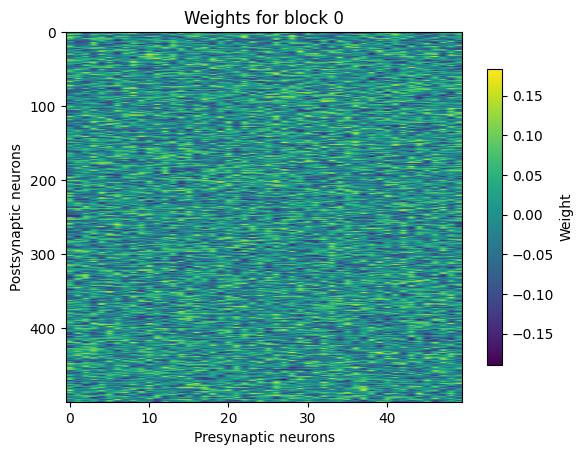

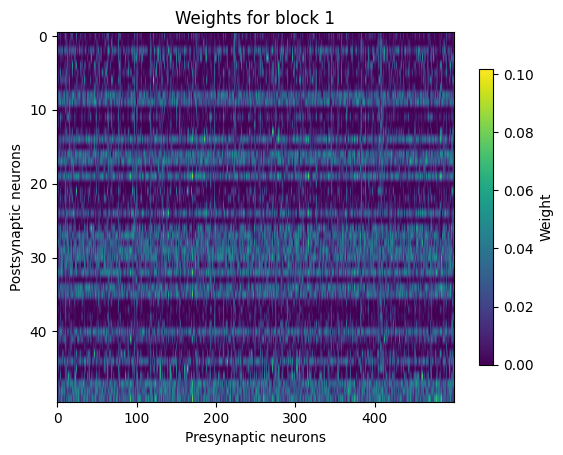

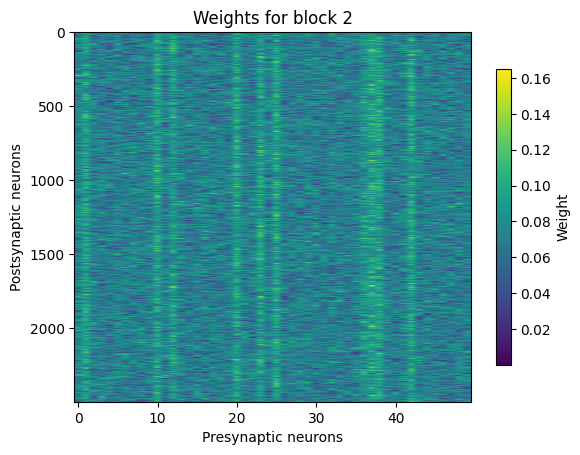

In [ ]:
for i in range(len(layer_sizes)-1):
    hybrid_network.plot_weights(i)

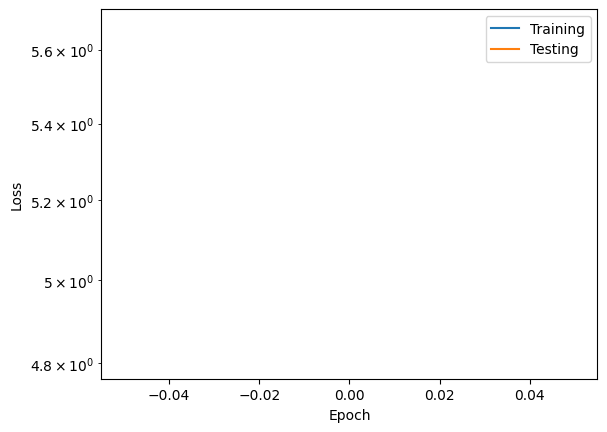

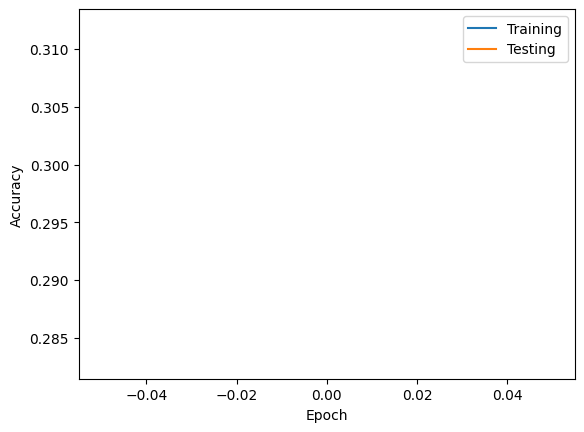

In [ ]:
stats.plot()

## Inference with trained weights

In [ ]:
# Loading the model
hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_learning_rate,
    stdp_tau_combined, train_hybrid=True, burn_in=50).to(device)
hybrid_network.load_state_dict(torch.load(trained_folder + '/network.pt'))
# Retrieving one batch of testing examples
data, label = next(iter(testing_loader))
# Passing through the network and getting the readout of the last layer only
with torch.no_grad():
    readouts, _ = assistant.test(data, (one_hot(label.to(torch.int64), num_classes=n_class)))

# Softmaxing to get a probability distribution over all possible classes at
# each timepoint, then finding the index of the largest probability value
# for each timepoint, then finding the mode of these indices across all timepoints
values, _ = torch.mode(\
                torch.argmax(\
                    torch.nn.functional.softmax(\
                        readouts, dim=1), dim=1), dim=1)

print('Predictions:')
print(values.tolist()[0:20])
print('Ground truths')
print(label.tolist()[0:20])